# <center>`PROBLEM STATEMENT`</center>

### `Objective:`  
- The goal of this project is to develop a linear regression model to predict the prices of houses based on their square footage, number of bedrooms, and number of bathrooms. This predictive model can be used by real estate agents, potential buyers, and sellers to estimate the market value of a property.

## `-> Importing Libraries`


In [1]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error

import joblib
import pickle

In [2]:
data = pd.read_csv('../data/housing_price_dataset.csv')

## `-> Information about data`

In [3]:
data.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


In [4]:
print(f'Number of rows -> {data.shape[0]}', f'\nNumber of columns -> {data.shape[1]}')

Number of rows -> 50000 
Number of columns -> 6


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


In [6]:
data.describe()

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Price
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2006.374680,3.498700,1.995420,1985.404420,224827.325151
std,575.513241,1.116326,0.815851,20.719377,76141.842966
min,1000.000000,2.000000,1.000000,1950.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,1967.000000,169955.860225
50%,2007.000000,3.000000,2.000000,1985.000000,225052.141166
75%,2506.000000,4.000000,3.000000,2003.000000,279373.630052
max,2999.000000,5.000000,3.000000,2021.000000,492195.259972


In [7]:
print(data.columns)

Index(['SquareFeet', 'Bedrooms', 'Bathrooms', 'Neighborhood', 'YearBuilt',
       'Price'],
      dtype='object')


###  Features that the model should be trained on:
- Square footage
- Number of bedrooms
- Number of bathrooms

In [8]:
selected_features = ['SquareFeet', 'Bedrooms', 'Bathrooms', 'Price']

In [9]:
fdata = data.loc[:,selected_features]
fdata.head()

,SquareFeet,Bedrooms,Bathrooms,Price
0,2126,4,1,215355.283618
1,2459,3,2,195014.221626
2,1860,2,1,306891.012076
3,2294,2,1,206786.787153
4,2130,5,2,272436.239065


In [10]:
fdata.describe()

,SquareFeet,Bedrooms,Bathrooms,Price
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,2006.374680,3.498700,1.995420,224827.325151
std,575.513241,1.116326,0.815851,76141.842966
min,1000.000000,2.000000,1.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,169955.860225
50%,2007.000000,3.000000,2.000000,225052.141166
75%,2506.000000,4.000000,3.000000,279373.630052
max,2999.000000,5.000000,3.000000,492195.259972


## `1. Data Preparation`

- Handling Null Values
- Handling Duplicates

In [11]:
null_cols = list()
for col in fdata.columns:
    if fdata[col].isnull().sum() != 0: null_cols.append(col)
print(f'\033[1mAll the columns containing null values ->\033[0m',null_cols)

All the columns containing null values -> []


In [12]:
dups = fdata.duplicated().sum()
print(f'There were \033[1m{dups}\033[0m duplicates in the data')
fdata = fdata.drop_duplicates()
print(f'There are \033[1m{fdata.duplicated().sum()}\033[0m duplicates in the data')

There were 0 duplicates in the data
There are 0 duplicates in the data


## `2. Exploratory Data Analysis`

In [13]:
fdata.head()

,SquareFeet,Bedrooms,Bathrooms,Price
0,2126,4,1,215355.283618
1,2459,3,2,195014.221626
2,1860,2,1,306891.012076
3,2294,2,1,206786.787153
4,2130,5,2,272436.239065


### `2.1 Data Visualization`

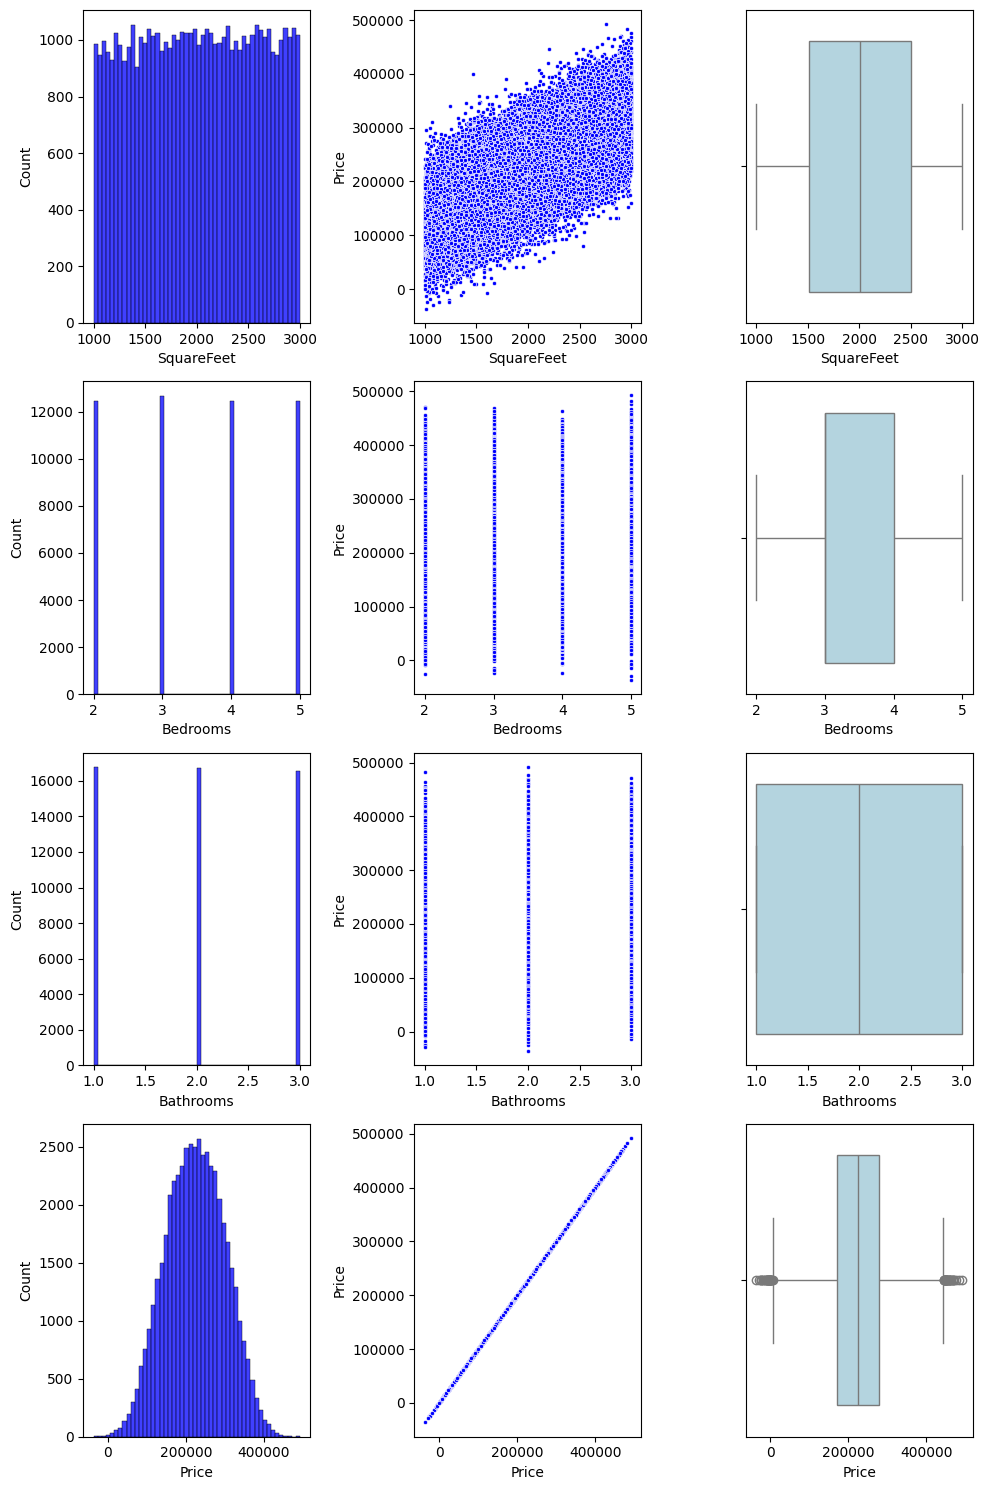

In [14]:
fig, ax = plt.subplots(nrows = len(fdata.columns), ncols = 3, figsize= (10,15))
for index, col in enumerate(fdata.columns):
    sns.histplot(x = fdata[col], ax = ax[index,0], bins = 50, color = 'blue')
    sns.scatterplot(x = fdata[col], y=fdata['Price'], ax = ax[index,1], marker = '.', color = 'blue')
    sns.boxplot(data = fdata[col], ax = ax[index,2], orient = 'h', color = 'lightblue')
    fig.tight_layout()
plt.show()

### `2.3 Plotting the Correlation of Predicting Features over Target Features`

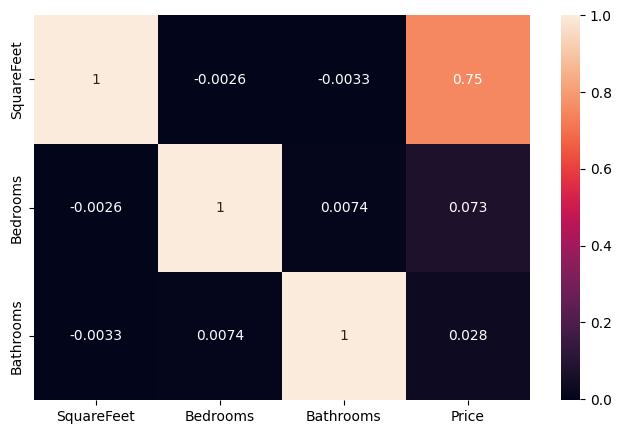

In [15]:
corr = fdata.corr()[:-1]
fig, ax = plt.subplots(figsize = (8,5))
sns.heatmap(data = corr, color = 'blue', annot = True, ax = ax)
plt.show()

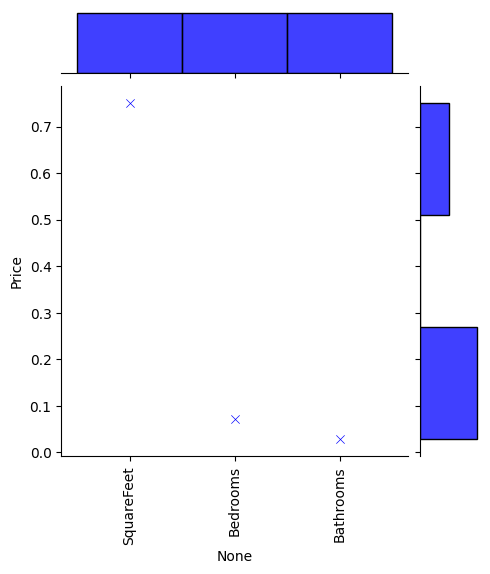

In [16]:
sns.jointplot(data = corr.Price, kind = 'scatter', color = 'blue', height=5, marker = 'x')
plt.xticks(rotation = 90)
plt.show()

In [17]:
main_features = list()
# corr.SalePrice[:-1][abs(corr.SalePrice[:-1]) > 0.25]
corr = fdata.corr()
abs(corr.Price[:-1]).sort_values()

Bathrooms     0.028418
Bedrooms      0.072624
SquareFeet    0.750720
Name: Price, dtype: float64

## `3. Handling Outliers`

(50000, 4)


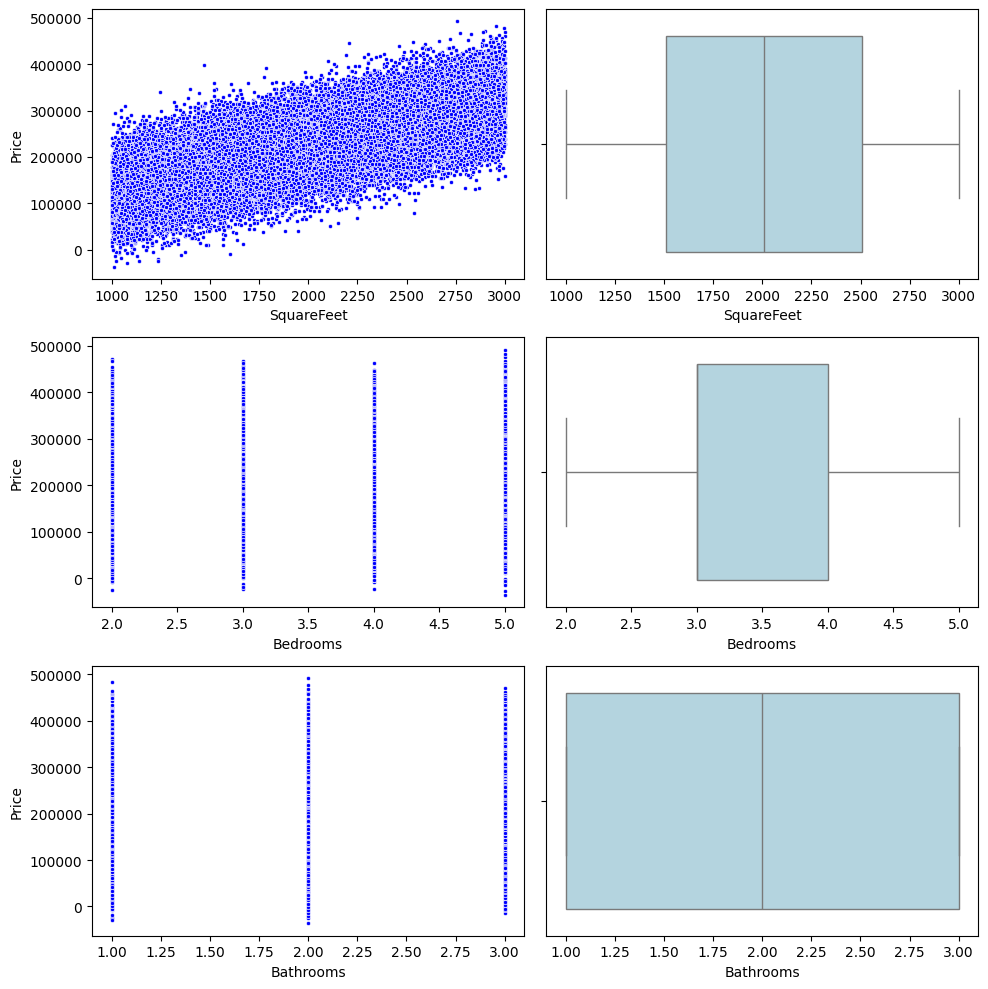

In [18]:
# boxplots of each feature
print(fdata.shape)
fig, ax = plt.subplots(nrows = len(fdata.columns) - 1, ncols = 2, figsize = (10,10))
for index, col in enumerate(fdata.columns[:-1]):
    sns.scatterplot(x = fdata[col] ,y = fdata['Price'], ax = ax[index][0], marker = '.', color = 'blue')
    sns.boxplot(x = fdata[col], ax = ax[index][1], color = 'lightblue')
plt.tight_layout()
plt.show()

In [19]:
fdata.columns

Index(['SquareFeet', 'Bedrooms', 'Bathrooms', 'Price'], dtype='object')

(50000, 4)


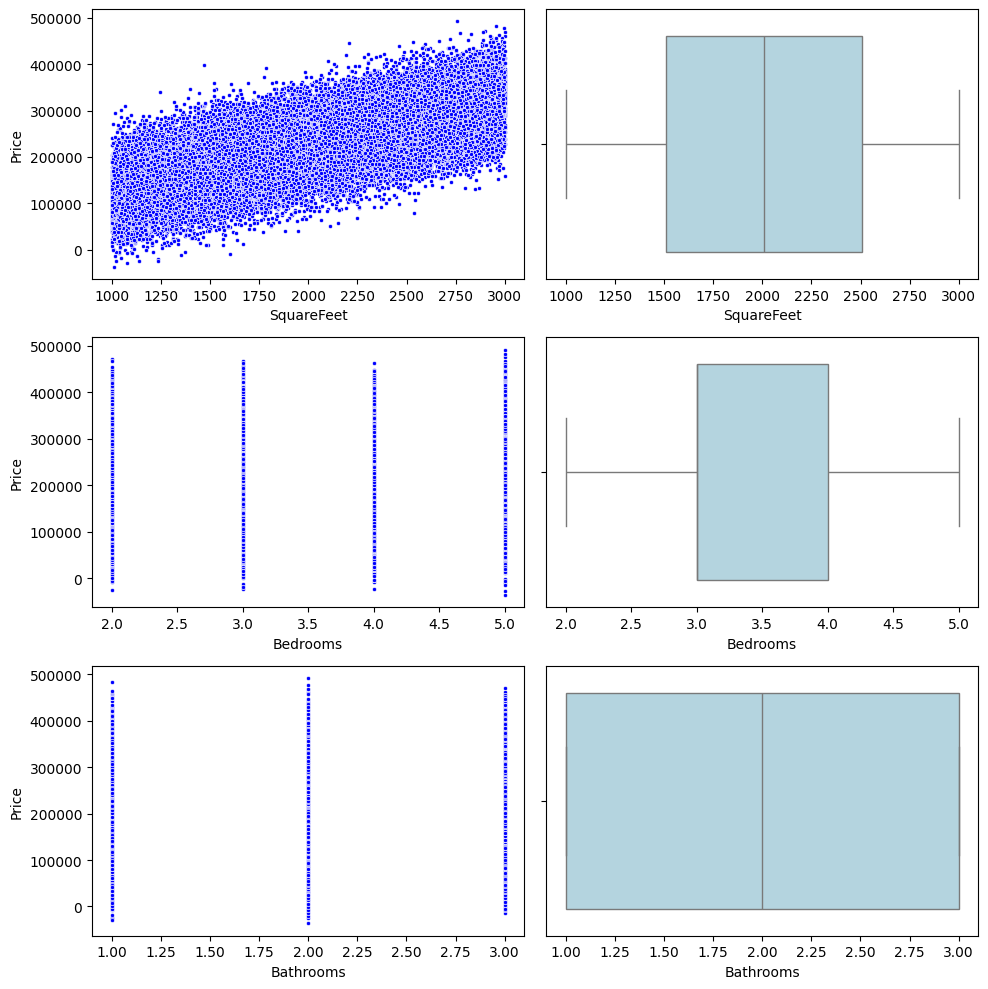

In [20]:
# boxplots of each feature
print(fdata.shape)
fig, ax = plt.subplots(nrows = len(fdata.columns) - 1, ncols = 2, figsize = (10,10))
for index, col in enumerate(fdata.columns[:-1]):
    sns.scatterplot(x = fdata[col],y = fdata['Price'], ax = ax[index][0], marker = '.', color = 'blue')
    sns.boxplot(x = fdata[col], ax = ax[index][1], color = 'lightblue')
plt.tight_layout()
plt.show()

## `4. Model Training`

### `4.1 Training Pipeline`

In [21]:
def training():
    scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
    models = [LinearRegression(), Lasso(), Ridge()]
    
    X = fdata.iloc[:,:-1]
    Y = fdata.Price
    
    results = []
    
    for scaler in scalers:
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=123)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        for model in models:
            trained_model = model.fit(X_train, y_train)
            pred = trained_model.predict(X_test)
            
            mse = mean_squared_error(y_test, pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, pred)
            mape = mean_absolute_percentage_error(y_test, pred)
            r2 = r2_score(y_test, pred)
            
            result = {
                'model': model,
                'scaler': scaler,
                'mse': mse,
                'rmse': rmse,
                'mae': mae,
                'mape': mape,
                'r2': r2
            }
            
            results.append(result)
            
            print(model, scaler)
            print(f'mse -> {mse}')
            print(f'rmse -> {rmse}')
            print(f'mae -> {mae}')
            print(f'mape -> {mape}')
            print(f'r2 -> {r2}', '\n')
            
        # best model on r2 score
    best_result = max(results, key=lambda x: x['r2'])

    print("Best Model:")
    print(f"Model: {best_result['model']}")
    print(f"Scaler: {best_result['scaler']}")
    print(f"R2 Score: {best_result['r2']}")
    print(f"MSE: {best_result['mse']}")
    print(f"RMSE: {best_result['rmse']}")
    print(f"MAE: {best_result['mae']}")
    print(f"MAPE: {best_result['mape']} \n")

In [22]:
training()

LinearRegression() StandardScaler()
mse -> 2507409900.2203946
rmse -> 50074.04417680276
mae -> 40055.3171697362
mape -> 0.2610652890674736
r2 -> 0.5676124139035713 

Lasso() StandardScaler()
mse -> 2507409094.4415083
rmse -> 50074.03613092825
mae -> 40055.31192550015
mape -> 0.2610662942397622
r2 -> 0.5676125528552391 

Ridge() StandardScaler()
mse -> 2507410265.64269
rmse -> 50074.04782562211
mae -> 40055.322321308384
mape -> 0.2610669229458857
r2 -> 0.567612350888719 

LinearRegression() MinMaxScaler()
mse -> 2507409900.2203946
rmse -> 50074.04417680276
mae -> 40055.3171697362
mape -> 0.2610652890674737
r2 -> 0.5676124139035712 

Lasso() MinMaxScaler()
mse -> 2507408271.793745
rmse -> 50074.02791661307
mae -> 40055.30832517845
mape -> 0.26106884542601894
r2 -> 0.5676126947158422 

Ridge() MinMaxScaler()
mse -> 2507414975.47393
rmse -> 50074.094854265015
mae -> 40055.382474674
mape -> 0.2610849713060688
r2 -> 0.5676115387069691 

LinearRegression() RobustScaler()
mse -> 2507409900.220

### `5.2 HyperParameter Tuning for the best model`

In [23]:
# using GridSearchCV
model = Ridge()
rs = RobustScaler(unit_variance=True)

X = fdata.iloc[:,:-1]
Y = fdata.Price

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=123)
X_train = rs.fit_transform(X_train)
X_test = rs.transform(X_test)

params = {
    'alpha':[0.1, 0.01, 0.001, 0.0001, 0.00001], 
    'fit_intercept':[True, False],
    'copy_X':[True, False],
    'max_iter':np.arange(1000,10000,1000),
    'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
    'positive':[True, False],
}

gs = GridSearchCV(estimator=Ridge(), param_grid=params, n_jobs=-1, verbose=4)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits


GridSearchCV(estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'max_iter': array([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]),
                         'positive': [True, False],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga', 'lbfgs']},
             verbose=4)

In [24]:
r_bps = gs.best_params_
print(r_bps)

{'alpha': 0.0001, 'copy_X': False, 'fit_intercept': True, 'max_iter': np.int64(7000), 'positive': False, 'solver': 'sag'}


In [25]:
r_model = gs.best_estimator_
r_trained_model = model.fit(X_train, y_train)
pred = r_trained_model.predict(X_test)

In [26]:
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f'R2 Score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

R2 Score: 0.5661219803144399
MSE: 2516052904.916129
RMSE: 50160.272177452636
MAE: 40137.091041143205
MAPE: 0.26479094633301803


### `5.3 Traning Linear Regression Model`

In [27]:
# using GridSearchCV
model = LinearRegression()
rs = RobustScaler(unit_variance=True)

X = fdata.iloc[:,:-1]
Y = fdata.Price

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=123)
X_train = rs.fit_transform(X_train)
X_test = rs.transform(X_test)

params = {
    'fit_intercept':[True, False],
    'copy_X':[True, False],
    'n_jobs':np.arange(1,100,1),
    'positive':[True, False],
}

gs = GridSearchCV(estimator=LinearRegression(), param_grid=params, n_jobs=-1, verbose=4)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 792 candidates, totalling 3960 fits


GridSearchCV(estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                         'positive': [True, False]},
             verbose=4)

In [28]:
lr_bps = gs.best_params_
print(lr_bps)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': np.int64(1), 'positive': True}


In [29]:
lr_model = gs.best_estimator_ 
lr_trained_model = model.fit(X_train, y_train)
pred = lr_trained_model.predict(X_test)

In [30]:
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f'R2 Score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

R2 Score: 0.5676124139035712
MSE: 2507409900.2203946
RMSE: 50074.04417680276
MAE: 40055.3171697362
MAPE: 0.26106528906747384


## `6. Evaluating Model`

In [31]:
lr_train_pred = lr_model.predict(X_train)
r_train_pred = r_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)
r_test_pred = r_model.predict(X_test)


lr_train_data = pd.DataFrame({'y_train' : y_train, 'train_pred' : lr_train_pred})
r_train_data = pd.DataFrame({'y_train' : y_train, 'train_pred' : r_train_pred})

lr_pred_data = pd.DataFrame({'y_test' : y_test, 'test_pred' : lr_test_pred})
r_pred_data = pd.DataFrame({'y_test' : y_test, 'test_pred' : r_test_pred})

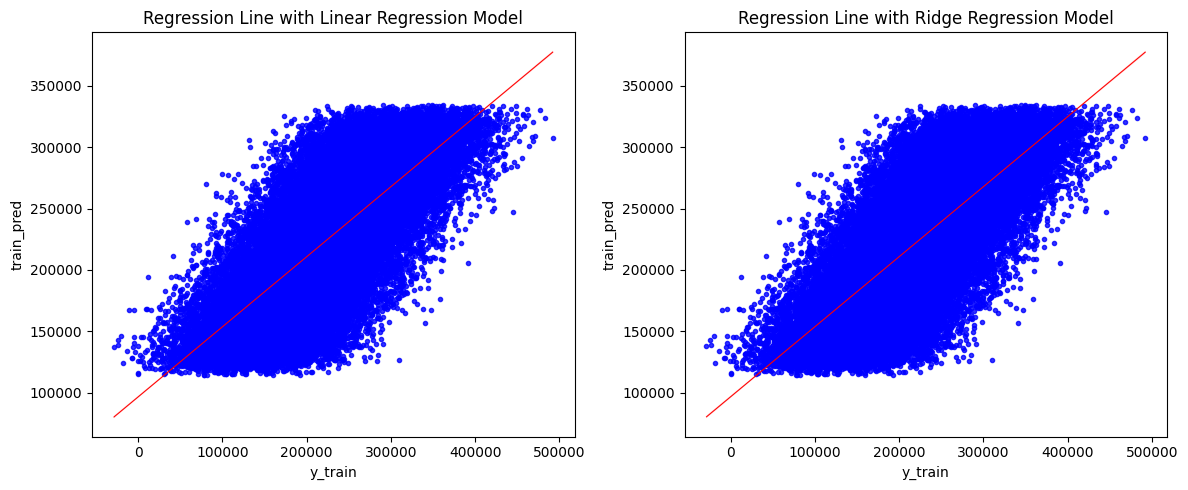

In [32]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
sns.regplot(ax = ax[0], data = lr_train_data, x = 'y_train', y = 'train_pred', marker = '.', scatter_kws={'color': 'blue'}, line_kws={'color': 'red', 'linewidth': 0.75})
ax[0].set_title(f'Regression Line with Linear Regression Model')

sns.regplot(ax = ax[1], data = r_train_data, x = 'y_train', y = 'train_pred', marker = '.', scatter_kws={'color': 'blue'}, line_kws={'color': 'red', 'linewidth': 0.75})
ax[1].set_title(f'Regression Line with Ridge Regression Model')

plt.tight_layout()
plt.show()

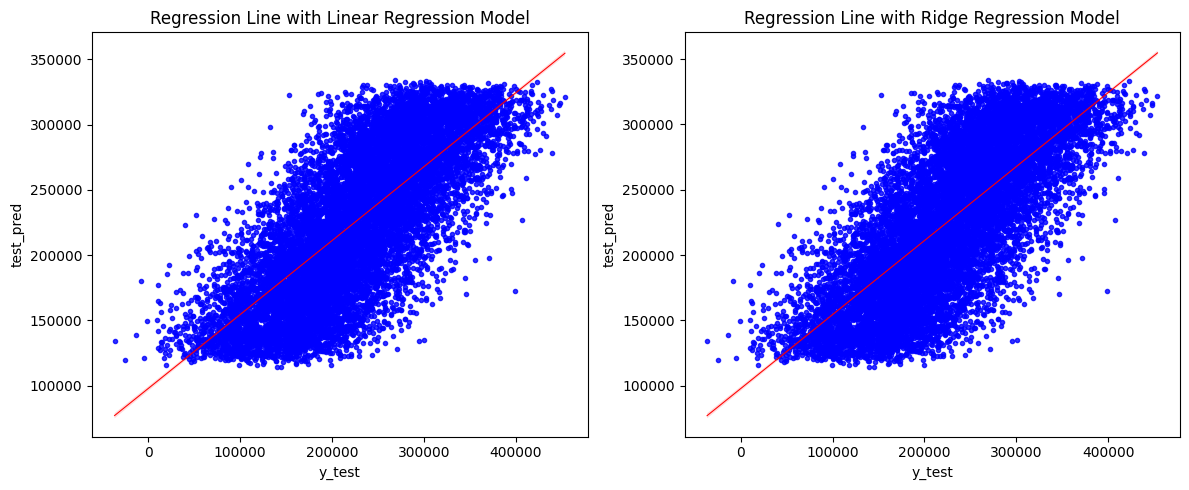

In [33]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
sns.regplot(ax = ax[0], data = lr_pred_data, x = 'y_test', y = 'test_pred', marker = '.', scatter_kws={'color': 'blue'}, line_kws={'color': 'red', 'linewidth': 0.75})
ax[0].set_title(f'Regression Line with Linear Regression Model')

sns.regplot(ax = ax[1], data = r_pred_data, x = 'y_test', y = 'test_pred', marker = '.', scatter_kws={'color': 'blue'}, line_kws={'color': 'red', 'linewidth': 0.75})
ax[1].set_title(f'Regression Line with Ridge Regression Model')

plt.tight_layout()
plt.show()

## `7. Exporting Model`

In [34]:
models_path = 'models'
joblib.dump(r_trained_model, filename='../models/Linear_Regression_l2Regularizer_model.pkl')
joblib.dump(lr_trained_model, filename='../models/Linear_Regression_model.pkl')

['../models/Linear_Regression_model.pkl']

In [35]:
fdata.columns

Index(['SquareFeet', 'Bedrooms', 'Bathrooms', 'Price'], dtype='object')

In [36]:
fdata.head()

,SquareFeet,Bedrooms,Bathrooms,Price
0,2126,4,1,215355.283618
1,2459,3,2,195014.221626
2,1860,2,1,306891.012076
3,2294,2,1,206786.787153
4,2130,5,2,272436.239065


In [37]:
print('done')

done
